In [35]:
# This file provide template to download and work with the TinyImageNet dataset

In [36]:
# Please make sure GPU is disabled for this inference part of the lab
# Disable GPU and enable xla flags
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import pathlib
import numpy as np
import tensorflow as tf
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

In [37]:
# Make sure that unzipped tiny-imagenet-200 folder is placed in the current directory
#define path to the dataset
path = pathlib.Path('/local/tiny-imagenet-200')

In [38]:
# Map the wnids to integer labels to words
with open(os.path.join(path, 'wnids.txt'), 'r') as f:
  wnids = [x.strip() for x in f]


# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.join(path, 'words.txt'), 'r') as f:
  wnid_to_words = dict(line.split('\t') for line in f)
  for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
class_names = [wnid_to_words[wnid] for wnid in wnids]

In [39]:
# Import necessary packages
from __future__ import print_function
from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
import platform
from tqdm import tqdm
import random
from imageio import imread
from imageio import imsave


# Function for loading the tiny imagenet data
def load_tiny_imagenet(path, is_training=True, dtype=np.float32, subtract_mean=True, debug=False, debug_nclass=3):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Note: The original implementation loaded data as NCHW, I (tyler) changed it to NHWC

    Inputs:
    - path: String giving path to the directory to load.
    - is_training: If True, dont load testing data, if False, dont load training and val data
        Note: Must always load training data in order to subtract_mean.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.
    - debug: Whether or not to load a small number of classes for debugging

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 64, 64, 3) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 64, 64, 3) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 64, 64, 3) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (64, 64, 3) array giving mean training image
    - label_to_wnid: dictionary with mapping from integer class label to wnid
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
    label_to_wnid = {v: k for k, v in wnid_to_label.items()}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    if debug:
        print('Debug is on! Only loading %d / %d training classes.'
                  % (debug_nclass, len(wnids)))

    # Next load training data.
    X_train, y_train = [], []
    train_wnids = wnids[:debug_nclass] if debug else wnids
    for i, wnid in tqdm(enumerate(train_wnids), total=len(train_wnids)):
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 64, 64, 3), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:   ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    X_val, y_val = None, None
    if is_training:
        print('loading validation data')
        with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
            img_files = []
            val_wnids = []
            for line in f:
                img_file, wnid = line.split('\t')[:2]
                img_files.append(img_file)
                val_wnids.append(wnid)
            num_val = len(img_files)
            y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
            X_val = np.zeros((num_val, 64, 64, 3), dtype=dtype)
            for i, img_file in tqdm(enumerate(img_files), total=len(img_files)):
                img_file = os.path.join(path, 'val', 'images', img_file)
                img = imread(img_file)
                if img.ndim == 2:
                    img.shape = (64, 64, 1)
                X_val[i] = img

    mean_image = None
    if subtract_mean:
        mean_image = X_train.mean(axis=0)
        if is_training:
            X_train -= mean_image[None]
            X_val -= mean_image[None]
        else:
            X_test -= mean_image[None]

    if not is_training:
        X_train = None
        y_train = None

    return {
      'class_names': class_names,
      'X_train': X_train,
      'y_train': y_train,
      'X_val': X_val,
      'y_val': y_val,
      'mean_image': mean_image,
      'label_to_wnid': label_to_wnid
    }


In [40]:
print ("Loading Tiny-Imagenet Dataset for training and validation data")
dataset_train_val = load_tiny_imagenet(path, is_training = True, dtype=np.float32, subtract_mean=False)
x_val = dataset_train_val["X_val"] # 10000 images when each is a 64*64*3
y_val = dataset_train_val["y_val"] # 10000 elements

# Newly Added
class_names = dataset_train_val["class_names"]
print("All class names")
print(class_names)

Loading Tiny-Imagenet Dataset for training and validation data


100%|█████████████████████████████████████████| 200/200 [01:07<00:00,  2.95it/s]


loading validation data


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1523.93it/s]

All class names
[['Egyptian cat'], ['reel'], ['volleyball'], ['rocking chair', 'rocker'], ['lemon'], ['bullfrog', 'Rana catesbeiana'], ['basketball'], ['cliff', 'drop', 'drop-off'], ['espresso'], ['plunger', "plumber's helper"], ['parking meter'], ['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian'], ['dining table', 'board'], ['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus'], ['brown bear', 'bruin', 'Ursus arctos'], ['school bus'], ['pizza', 'pizza pie'], ['guinea pig', 'Cavia cobaya'], ['umbrella'], ['organ', 'pipe organ'], ['oboe', 'hautboy', 'hautbois'], ['maypole'], ['goldfish', 'Carassius auratus'], ['potpie'], ['hourglass'], ['seashore', 'coast', 'seacoast', 'sea-coast'], ['computer keyboard', 'keypad'], ['Arabian camel', 'dromedary', 'Camelus dromedarius'], ['ice cream', 'icecream'], ['nail'], ['space heater'], ['cardigan'], ['baboon'], ['snail'], ['coral reef'], ['albatross', 'mollymawk'], ['spider web', "spider's web"], ['sea cu

In [41]:
# Normalize all the float data between 0 and 1
x_val = x_val/255.0

In [42]:
# one hot encode y data
from tensorflow.keras.utils import to_categorical
num_classes = 200
y_val = to_categorical(y_val, num_classes)

['bee']


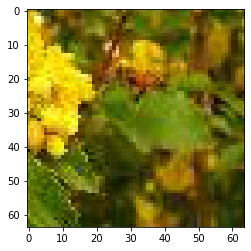

In [43]:
# E.g. visualization of one of the validation set image
import matplotlib.pyplot as plt
image_num = 102
arr_ = np.squeeze(x_val[image_num]) # you can give axis attribute if you wanna squeeze in specific dimension

# Debug
# print(label_to_wnid)
# print(y_val)
# print(len(class_names))
# print(len(y_val[100]))

# print(y_val[100])
# print(class_names[100])

# Finds classification from ML (by mapping)
def label_classification(image_number):
    index = 0
    for i in y_val[image_number]:
        if (i == 0):
            index = index + 1
        else:
            break
        
    return index

index = label_classification(image_num)
# print(index)
print(class_names[index])

plt.imshow(arr_)
plt.show()

In [44]:
# To do:  Load the H5 model and print summary. Please make sure the h5 model file is present in the current directory.
# Sample code to load the model
model = tf.keras.models.load_model('/local/jupyter/cpre482x-lab1/Inference/Template_Jupyter/CNN_tinyimagenet.h5', compile=False)


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [46]:
# # To do: Calculate Top-1, Top-5 accuracy on the validation set
# # E.g. to calculate Top-10 accuracy
# # Top-10 acc
# acc_top10=0
# acc_top5=0
# acc_top1=0
# for i in range(10000):
#     t=x_val[i].reshape(1,64,64,3)
#     y_pred= model.predict(t)
#     y_true= np.argmax(y_val[i])
#     S0=tf.math.top_k(y_pred, k=10, sorted=True, name=None)
#     S1=tf.math.top_k(y_pred, k=5, sorted=True, name=None)
#     S2=tf.math.top_k(y_pred, k=1, sorted=True, name=None)
#     z0=(S0.indices.numpy())
#     z1=(S1.indices.numpy())
#     z2=(S2.indices.numpy())
#     if(y_true in z0):
#         acc_top10=acc_top10+1
#     if(y_true in z1):
#         acc_top5=acc_top5+1
#     if(y_true in z2):
#         acc_top1=acc_top1+1        


In [47]:
# print(acc_top10/10000)
# print(acc_top5/10000)
# print(acc_top1/10000)


In [48]:
# To do: Print and visualize three inputs from the validation set. As an example, you may pick x_val[1], x_val[2] and x_val[3]
numb_0 = 94
numb_1 = 45
numb_2 = 10

# test_image_0 = x_val[numb_0]
# test_image_1 = x_val[numb_1]
# test_image_2 = x_val[numb_2]
# index0 = label_classification(numb_0)
# index1 = label_classification(numb_1)
# index2 = label_classification(numb_2)

# arr0_ = np.squeeze(test_image_0)
# print(class_names[index0])
# print(arr0_.dtype)
# print(arr0_.shape)
# print("Bits: {}. Bytes: {}.".format(arr0_.size * 32,arr0_.size * 4))
# plt.imshow(arr0_)
# plt.show()

# arr1_ = np.squeeze(test_image_1)
# print(class_names[index1])
# print(arr1_.dtype)
# print(arr1_.shape)
# print("Bits: {}. Bytes: {}.".format(arr1_.size * 32,arr1_.size * 4))
# plt.imshow(arr1_)
# plt.show()

# arr2_ = np.squeeze(test_image_2)
# print(class_names[index2])
# print(arr2_.dtype)
# print(arr2_.shape)
# print("Bits: {}. Bytes: {}.".format(arr2_.size * 32,arr2_.size * 4))
# plt.imshow(arr2_)
# plt.show()

# # To do: Print the data type
# # To do: Print and note the dimensions of each image
# # To do: Print the memory required to store each image 

In [49]:
# To do:  Export each of the three inputs to a binary file which will be used to load later in a C program.
# Example code to export x_val[0] to a binary file:

# Load in a numpy array. # we flatten the array before exporting to binary file. So 64*64*3= 12288 elements 1d array
# NOTE *** So we must reshape before loading in a C program

inp0 = np.asarray(x_val[numb_0].flatten())
inp1 = np.asarray(x_val[numb_1].flatten())
inp2 = np.asarray(x_val[numb_2].flatten())

# Save in a binary file i.e. numpy.ndarray.to_file()

f_input = open("input0.bin","wb")
inp0.tofile(f_input)
f_input.close()

f_input = open("input1.bin","wb")
inp1.tofile(f_input)
f_input.close()

f_input = open("input2.bin","wb")
inp2.tofile(f_input)
f_input.close()

# f_input=open("input.bin","wb")
# inp.tofile(f_input)
# f_input.close()

Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100e05b0d0>
  Dimensions of Weights: (5, 5, 3, 32)
  Dimensions of Biases: (32,)
  Data: 2400 float32


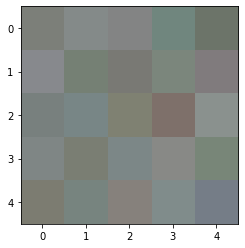

Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100e4bb760>
  Dimensions of Weights: (5, 5, 32, 32)
  Dimensions of Biases: (32,)
  Data: 25600 float32


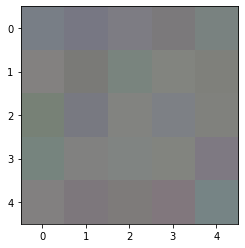

Current Layer: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f100cd44490>
  Layer does not have weights or biases
Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100d549550>
  Dimensions of Weights: (3, 3, 32, 64)
  Dimensions of Biases: (64,)
  Data: 18432 float32


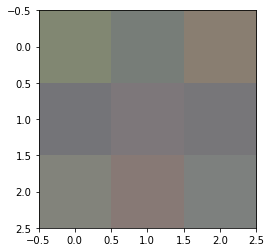

Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100c32db20>
  Dimensions of Weights: (3, 3, 64, 64)
  Dimensions of Biases: (64,)
  Data: 36864 float32


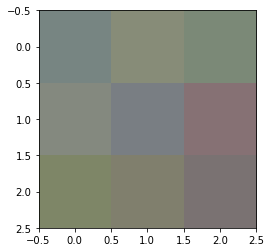

Current Layer: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f100d5499a0>
  Layer does not have weights or biases
Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100e003490>
  Dimensions of Weights: (3, 3, 64, 64)
  Dimensions of Biases: (64,)
  Data: 36864 float32


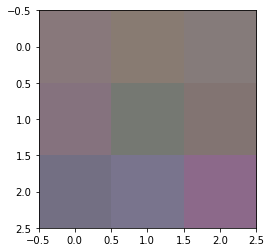

Current Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f100dfeffa0>
  Dimensions of Weights: (3, 3, 64, 128)
  Dimensions of Biases: (128,)
  Data: 73728 float32


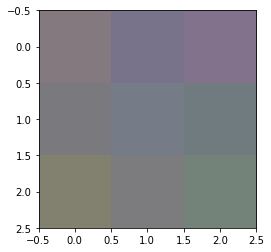

Current Layer: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f100dfef5e0>
  Layer does not have weights or biases
Current Layer: <tensorflow.python.keras.layers.core.Flatten object at 0x7f100df3c910>
  Layer does not have weights or biases
Current Layer: <tensorflow.python.keras.layers.core.Dense object at 0x7f10805b2df0>
  Dimensions of Weights: (2048, 256)
  Dimensions of Biases: (256,)
  Data: 524288 float32


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [50]:
# To do: Print/Visualize weights of all the layers.
for layer in model.layers:
    print("Current Layer: " + str(layer))
    data = layer.get_weights()
    if len(data) == 0:
        print("  Layer does not have weights or biases")
    else:
        weights = data[0]
        biases = data[1]
        print("  Dimensions of Weights: " + str(weights.shape))
        print("  Dimensions of Biases: " + str(biases.shape))
        print("  Data: " + str(len(weights.flatten())) + " " + str(weights.dtype))
        
        size = weights.shape
        for w in range(0, 1):
            img = np.zeros((size[0],size[1],3));
            for x in range(0, size[0]):
                for y in range(0, size[1]):
                    for z in range(0, 3):
                        img[x,y,z] = (weights[x,y,z,w] + 1) / 2 #normalize data to [0..1]
            plt.imshow(img)
            plt.show()


# To do: Print the data type
# To do: Print and note the dimensions of weights of each layer
# To do: Print the memory required to store the weights of each layer


In [ ]:
# To do:  (Similar to input ) Export all of the weights to a binary file which will be used to load later in a C program and use in the custom C/C++ inference implementation.

In [ ]:
# To do: Print/Visualize the intermediate feature maps for all of the layers for all three inputs.
# To do: Print the data type
# To do: Print and note the dimensions of intermediate feature maps of each layer
# To do: Print the memory required to store the intermediate feature maps of each layer

# Create a model which contains the intermediate feature maps
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)
input_image = np.asarray(x_val[numb_0].flatten()).reshape(1, 64, 64, 3)

# Predict so we have access to feature maps
feature_maps = feature_map_model.predict(input_image)
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

# Print the initial image
plt.imshow(input_image[0, :, :, 0])
plt.show()
    
# We now have layers - print images
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4: #We only want convolution (and pooling) layers (other layers don't have useful intermediate maps)
        print(str(layer_name) + " " + str(feature_map.shape))
        # Just print the first feature map for this layer
#         figure = plt.subplots(1, feature_map.shape[3])
        for output_map_id in range(0, 3): #print 3 feature maps
            output_map = feature_map[0, :, :, output_map_id]
            print(str(output_map.shape))
            plt.imshow(output_map)
            plt.show()


In [ ]:
!tar chvfz notebook.tar.gz *